# Example 3

## Performance and resource comparisons of Pythonic and JAX implementation of AISLE
In this example we compare the performance and resource utilization of anomaly detection with the use of AISLEX in pythonic and JAX implementation.

For this example we provide a sample of pretrained weights which are used below as benchmarking input.

In [1]:
# Import required libs
import json
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import perftester as pt
from memory_profiler import memory_usage

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# Get access to root folder of the notebook
sys.path.append("..")

# Pythonic AISLE
from src.aisle import aisle as py_aisle
from src.aisle import aisle_window as py_aisle_window

# JAX accelerated AISLE
from src.aisle_jax import aisle as jax_aisle
from src.aisle_jax import aisle_window as jax_aisle_window

%matplotlib widget

In [2]:
# Load input weights
data = pd.read_csv("example_3_data.csv")

# Prepare test constrains
setup = {
    "weight_test_min_weight_count": 1,
    "weight_test_max_weight_count": 1000,
    "weight_test_logSamples": 25,
    "weight_test_data_length": 10000,
    "data_length_min": 200,
    "data_length_max": 100000,
    "data_length_test_weights": 80,
    "data_length_test_window": 150,
    "data_length_test_logSamples": 25,
    "window_test_min": 5,
    "window_test_max": 1000,
    "window_test_data_length": 10000,
    "window_test_logSamples": 25,
    "test_alphas": (4, 5, 6),
    "test_oles": (1, 3, 5),
    "test_number": 5,
    "test_repeat": 4,
}


# Define data shaper for performance tests
def data_shaper(data: pd.DataFrame, data_length: int, weight_count: int) -> np.array:
    """Dynamically adds or removes data based on required inputs."""
    # Adjust the number of rows
    if len(data) > data_length:
        data = data.iloc[:data_length].copy()
    elif len(data) < data_length:
        additional_rows = data_length - len(data)
        replicated_data = pd.concat([data] * (additional_rows // len(data) + 1), ignore_index=True)
        data = replicated_data.iloc[:data_length].copy()

    # Adjust the number of columns
    current_columns = data.shape[1]
    if current_columns > weight_count:
        data = data.iloc[:, :weight_count]
    elif current_columns < weight_count:
        additional_columns = {}
        for i in range(current_columns, weight_count):
            source_col_index = (i - current_columns) % current_columns
            additional_columns[f"w{i}_e"] = data.iloc[:, source_col_index].values
        additional_columns_data = pd.DataFrame(additional_columns)
        data = pd.concat([data, additional_columns_data], axis=1)

    return data.to_numpy()


# Define a function to load benchmark results from JSON files
def load_benchmark_results(keys: str, directory: str = "../test_local/benchmarks") -> dict:
    """Loads JSON from directory."""
    benchmark_results = {}
    for key in keys:
        with open(f"{directory}/{key}.json") as file:
            benchmark_results[key] = json.load(file)
    return benchmark_results

### Data length performance evaluation
In this benchmark we measure execution times and memory usage for both, pythonic and jax accelerated methods

In [22]:
# Holders for results
python_length_times = []
python_length_memory = []
jax_length_times = []
jax_length_memory = []

# Generate logspace between min and max data length
data_lengths = np.logspace(
    np.log10(setup["data_length_min"]),
    np.log10(setup["data_length_max"]),
    num=setup["data_length_test_logSamples"],
)

for run, data_length in enumerate(data_lengths):
    test_data = data_shaper(data, int(data_length), setup["data_length_test_weights"])
    print(f"\rBenchmarking dataset {run+1} / {len(data_lengths)}...", end="", flush=True)

    # Validate settings
    if test_data.shape[0] < setup["data_length_test_window"]:
        msg = (
            f"Test data length {test_data.shape[0]} can not be lower than evaluation window",
            f"length {setup['data_length_test_window']}.",
        )
        raise OSError(msg)

    # Test execution times
    python_length_times.append(
        pt.time_benchmark(
            py_aisle_window,
            setup["data_length_test_window"],
            test_data,
            setup["test_alphas"],
            setup["test_oles"],
            Number=setup["test_number"],
            Repeat=setup["test_repeat"],
        )
    )
    jax_length_times.append(
        pt.time_benchmark(
            jax_aisle_window,
            setup["data_length_test_window"],
            test_data,
            setup["test_alphas"],
            setup["test_oles"],
            Number=setup["test_number"],
            Repeat=setup["test_repeat"],
        )
    )

    # Measure memory usages
    python_length_memory.append(
        memory_usage(
            (
                py_aisle_window,
                (
                    setup["data_length_test_window"],
                    test_data,
                    setup["test_alphas"],
                    setup["test_oles"],
                ),
            ),
            max_usage=True,
        )
    )

    jax_length_memory.append(
        memory_usage(
            (
                jax_aisle_window,
                (
                    setup["data_length_test_window"],
                    test_data,
                    setup["test_alphas"],
                    setup["test_oles"],
                ),
            ),
            max_usage=True,
        )
    )

Benchmarking dataset 1 / 25...

Benchmarking dataset 25 / 25...

In [23]:
# Save benchmarking results as JSONs
benchmark_results = {
    "python_length_times": python_length_times,
    "python_length_memory": python_length_memory,
    "jax_length_times": jax_length_times,
    "jax_length_memory": jax_length_memory,
}

for key, value in benchmark_results.items():
    with open(f"../test_local/benchmarks/{key}.json", "w") as file:
        json.dump(value, file, indent=1)


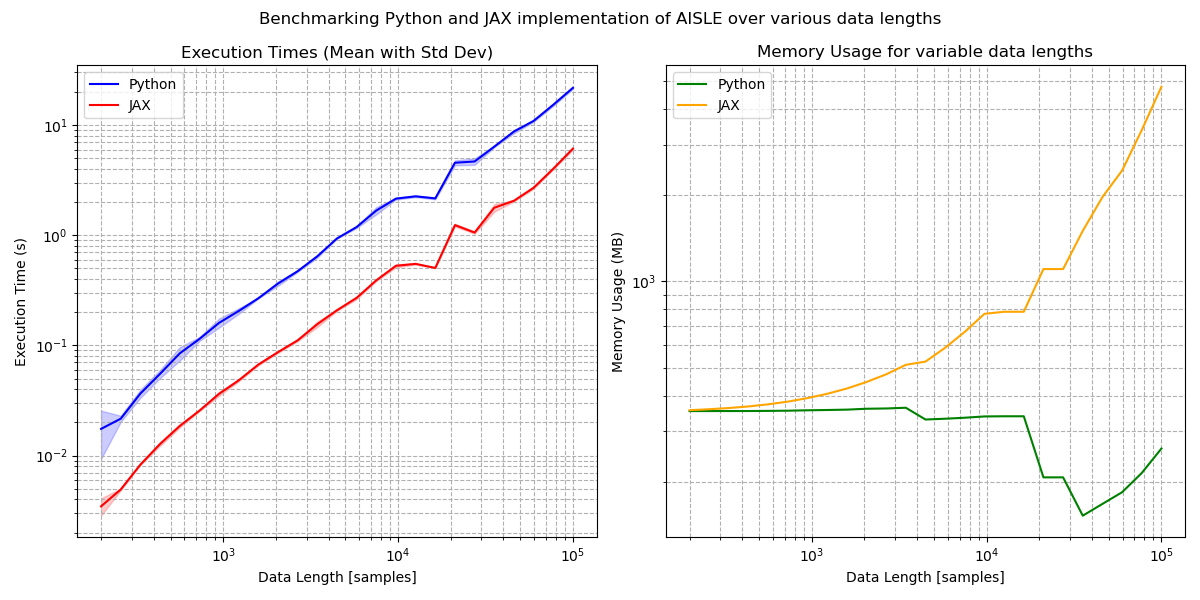

In [24]:
# Load benchmarking results from JSON files
keys = ["python_length_times", "python_length_memory", "jax_length_times", "jax_length_memory"]
benchmark_results = load_benchmark_results(keys)

# If you need to use the loaded data directly
python_length_times = benchmark_results["python_length_times"]
python_length_memory = benchmark_results["python_length_memory"]
jax_length_times = benchmark_results["jax_length_times"]
jax_length_memory = benchmark_results["jax_length_memory"]

# Extract the absolute minimum execution time from both Python and JAX window times
absolute_min_time = min(*(d["min"] for d in python_length_times), *(d["min"] for d in jax_length_times))

# Convert benchmarking stats to NumPy arrays
python_means = np.array([d["mean"] for d in python_length_times])
python_std = np.array([np.std(d["raw_times"], ddof=1) for d in python_length_times])
python_lower_bound = np.maximum(python_means - python_std, absolute_min_time)

jax_means = np.array([d["mean"] for d in jax_length_times])
jax_std = np.array([np.std(d["raw_times"], ddof=1) for d in jax_length_times])
jax_lower_bound = np.maximum(jax_means - jax_std, absolute_min_time)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Benchmarking Python and JAX implementation of AISLE over various data lengths")

# Execution times
ax1.plot(data_lengths, python_means, label="Python", color="blue")
ax1.fill_between(data_lengths, python_lower_bound, python_means + python_std, color="blue", alpha=0.2)
ax1.plot(data_lengths, jax_means, label="JAX", color="red")
ax1.fill_between(data_lengths, jax_lower_bound, jax_means + jax_std, color="red", alpha=0.2)
ax1.set_xlabel("Data Length [samples]")
ax1.set_ylabel("Execution Time (s)")
ax1.set_title("Execution Times (Mean with Std Dev)")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.legend()
ax1.grid(which="both", ls="--")

# Memory usage
ax2.plot(data_lengths, python_length_memory, label="Python", color="green")
ax2.plot(data_lengths, jax_length_memory, label="JAX", color="orange")
ax2.set_xlabel("Data Length [samples]")
ax2.set_ylabel("Memory Usage (MB)")
ax2.set_title("Memory Usage for variable data lengths")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.legend()
ax2.grid(which="both", ls="--")

plt.tight_layout()
plt.show()


In [6]:
plt.savefig("../test_local/images/3_length_memory.svg")

### Weight count performance evaluation
In this benchmark we measure execution time and memory usage for single AISLE evaluation over various weight counts

In [17]:
# Run data length test
python_weight_times = []
python_weight_memory = []
jax_weight_times = []
jax_weight_memory = []

# Generate logspace between min and max data length
weight_counts = np.logspace(
    np.log10(setup["weight_test_min_weight_count"]),
    np.log10(setup["weight_test_max_weight_count"]),
    num=setup["weight_test_logSamples"],
    dtype=np.int32,
)

for run, weight_count in enumerate(weight_counts):
    test_data = data_shaper(data, setup["weight_test_data_length"], weight_count)
    print(f"\rBenchmarking dataset {run+1} / {len(weight_counts)}...", end="", flush=True)

    # Test execution times
    python_weight_times.append(
        pt.time_benchmark(
            py_aisle,
            test_data,
            setup["test_alphas"],
            setup["test_oles"],
            Number=setup["test_number"],
            Repeat=setup["test_repeat"],
        )
    )
    jax_weight_times.append(
        pt.time_benchmark(
            jax_aisle,
            test_data,
            setup["test_alphas"],
            setup["test_oles"],
            Number=setup["test_number"],
            Repeat=setup["test_repeat"],
        )
    )

    # Measure memory usages
    python_weight_memory.append(
        memory_usage(
            (
                py_aisle,
                (
                    test_data,
                    setup["test_alphas"],
                    setup["test_oles"],
                ),
            ),
            max_usage=True,
        )
    )

    jax_weight_memory.append(
        memory_usage(
            (
                jax_aisle,
                (
                    test_data,
                    setup["test_alphas"],
                    setup["test_oles"],
                ),
            ),
            max_usage=True,
        )
    )

Benchmarking dataset 25 / 25...

In [18]:
# Save benchmarking results as JSONs
benchmark_results = {
    "python_weight_times": python_weight_times,
    "python_weight_memory": python_weight_memory,
    "jax_weight_times": jax_weight_times,
    "jax_weight_memory": jax_weight_memory,
}

for key, value in benchmark_results.items():
    with open(f"../test_local/benchmarks/{key}.json", "w") as file:
        json.dump(value, file, indent=1)


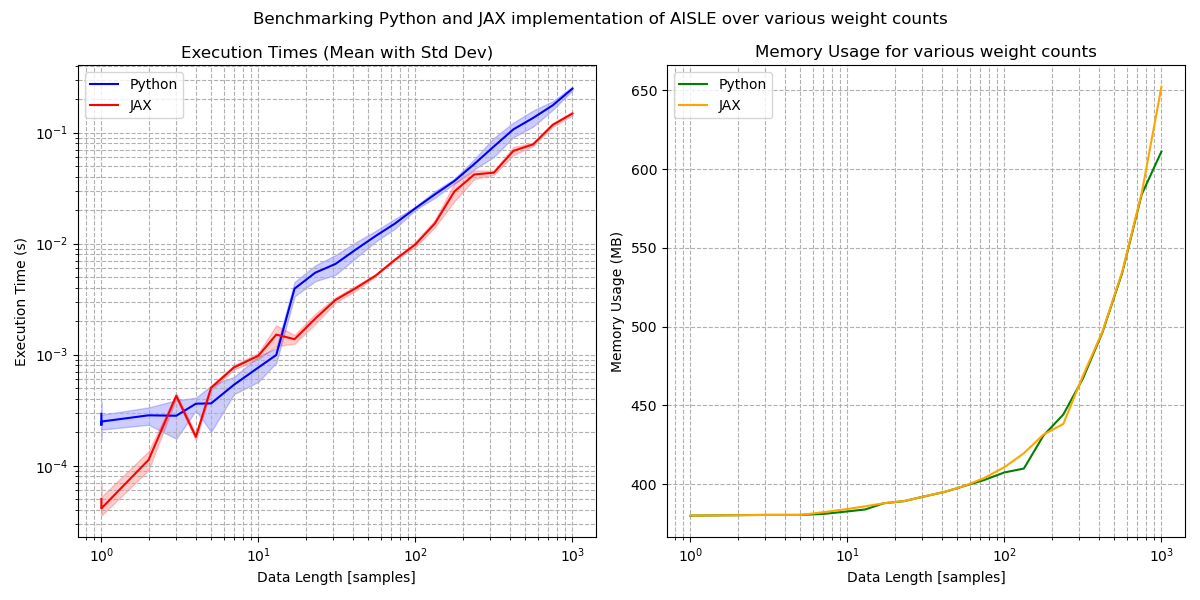

In [19]:
# Load benchmarking results from JSON files
keys = ["python_weight_times", "python_weight_memory", "jax_weight_times", "jax_weight_memory"]
benchmark_results = load_benchmark_results(keys)

# If you need to use the loaded data directly
python_weight_times = benchmark_results["python_weight_times"]
python_weight_memory = benchmark_results["python_weight_memory"]
jax_weight_times = benchmark_results["jax_weight_times"]
jax_weight_memory = benchmark_results["jax_weight_memory"]

# Extract the absolute minimum execution time from both Python and JAX window times
absolute_min_time = min(*(d["min"] for d in python_weight_times), *(d["min"] for d in jax_weight_times))

# Convert benchmarking stats to NumPy arrays
python_means = np.array([d["mean"] for d in python_weight_times])
python_std = np.array([np.std(d["raw_times"], ddof=1) for d in python_weight_times])
python_lower_bound = np.maximum(python_means - python_std, absolute_min_time)

jax_means = np.array([d["mean"] for d in jax_weight_times])
jax_std = np.array([np.std(d["raw_times"], ddof=1) for d in jax_weight_times])
jax_lower_bound = np.maximum(jax_means - jax_std, absolute_min_time)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Benchmarking Python and JAX implementation of AISLE over various weight counts")

# Execution times
ax1.plot(weight_counts, python_means, label="Python", color="blue")
ax1.fill_between(weight_counts, python_lower_bound, python_means + python_std, color="blue", alpha=0.2)
ax1.plot(weight_counts, jax_means, label="JAX", color="red")
ax1.fill_between(weight_counts, jax_lower_bound, jax_means + jax_std, color="red", alpha=0.2)
ax1.set_xlabel("Data Length [samples]")
ax1.set_ylabel("Execution Time (s)")
ax1.set_title("Execution Times (Mean with Std Dev)")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.legend()
ax1.grid(which="both", ls="--")

# Memory usage
ax2.plot(weight_counts, python_weight_memory, label="Python", color="green")
ax2.plot(weight_counts, jax_weight_memory, label="JAX", color="orange")
ax2.set_xlabel("Data Length [samples]")
ax2.set_ylabel("Memory Usage (MB)")
ax2.set_title("Memory Usage for various weight counts")
ax2.set_xscale("log")
ax2.set_yscale("linear")
ax2.legend()
ax2.grid(which="both", ls="--")

plt.tight_layout()
plt.show()


In [10]:
plt.savefig("../test_local/images/3_weight_memory.svg")

### Window length performance evaluation
In this benchmark we measure execution time and memory usage for AISLE evaluation over various window lengths

In [11]:
# Run data length test
python_window_times = []
python_window_memory = []
jax_window_times = []
jax_window_memory = []

# Generate logspace between min and max data length
window_counts = np.logspace(
    np.log10(setup["weight_test_min_weight_count"]),
    np.log10(setup["weight_test_max_weight_count"]),
    num=setup["weight_test_logSamples"],
    dtype=np.int32,
)

for run, window_count in enumerate(window_counts):
    test_data = data_shaper(data, setup["weight_test_data_length"], window_count)
    print(f"\rBenchmarking dataset {run+1} / {len(window_counts)}...", end="", flush=True)

    # Test execution times
    python_window_times.append(
        pt.time_benchmark(
            py_aisle,
            test_data,
            setup["test_alphas"],
            setup["test_oles"],
            Number=setup["test_number"],
            Repeat=setup["test_repeat"],
        )
    )
    jax_window_times.append(
        pt.time_benchmark(
            jax_aisle,
            test_data,
            setup["test_alphas"],
            setup["test_oles"],
            Number=setup["test_number"],
            Repeat=setup["test_repeat"],
        )
    )

    # Measure memory usages
    python_window_memory.append(
        memory_usage(
            (
                py_aisle,
                (
                    test_data,
                    setup["test_alphas"],
                    setup["test_oles"],
                ),
            ),
            max_usage=True,
        )
    )

    jax_window_memory.append(
        memory_usage(
            (
                jax_aisle,
                (
                    test_data,
                    setup["test_alphas"],
                    setup["test_oles"],
                ),
            ),
            max_usage=True,
        )
    )


Benchmarking dataset 25 / 25...

In [12]:
# Save benchmarking results as JSONs
benchmark_results = {
    "python_window_times": python_window_times,
    "python_window_memory": python_window_memory,
    "jax_window_times": jax_window_times,
    "jax_window_memory": jax_window_memory,
}

for key, value in benchmark_results.items():
    with open(f"../test_local/benchmarks/{key}.json", "w") as file:
        json.dump(value, file, indent=1)


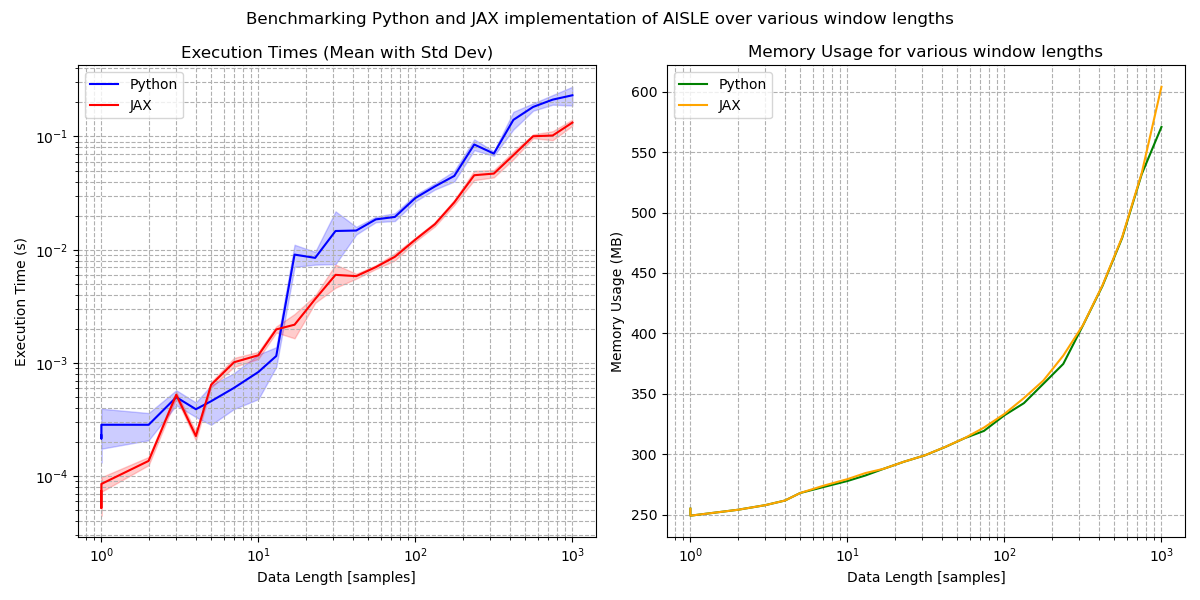

In [13]:
# Load benchmarking results from JSON files
keys = ["python_window_times", "python_window_memory", "jax_window_times", "jax_window_memory"]
benchmark_results = load_benchmark_results(keys)

# If you need to use the loaded data directly
python_window_times = benchmark_results["python_window_times"]
python_window_memory = benchmark_results["python_window_memory"]
jax_window_times = benchmark_results["jax_window_times"]
jax_window_memory = benchmark_results["jax_window_memory"]

# Extract the absolute minimum execution time from both Python and JAX window times
absolute_min_time = min(*(d["min"] for d in python_window_times), *(d["min"] for d in jax_window_times))

# Convert benchmarking stats to NumPy arrays
python_means = np.array([d["mean"] for d in python_window_times])
python_std = np.array([np.std(d["raw_times"], ddof=1) for d in python_window_times])
python_lower_bound = np.maximum(python_means - python_std, absolute_min_time)

jax_means = np.array([d["mean"] for d in jax_window_times])
jax_std = np.array([np.std(d["raw_times"], ddof=1) for d in jax_window_times])
jax_lower_bound = np.maximum(jax_means - jax_std, absolute_min_time)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Benchmarking Python and JAX implementation of AISLE over various window lengths")

# Execution times
ax1.plot(window_counts, python_means, label="Python", color="blue")
ax1.fill_between(window_counts, python_lower_bound, python_means + python_std, color="blue", alpha=0.2)
ax1.plot(window_counts, jax_means, label="JAX", color="red")
ax1.fill_between(window_counts, jax_lower_bound, jax_means + jax_std, color="red", alpha=0.2)
ax1.set_xlabel("Data Length [samples]")
ax1.set_ylabel("Execution Time (s)")
ax1.set_title("Execution Times (Mean with Std Dev)")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.legend()
ax1.grid(which="both", ls="--")

# Memory usage
ax2.plot(window_counts, python_weight_memory, label="Python", color="green")
ax2.plot(window_counts, jax_weight_memory, label="JAX", color="orange")
ax2.set_xlabel("Data Length [samples]")
ax2.set_ylabel("Memory Usage (MB)")
ax2.set_title("Memory Usage for various window lengths")
ax2.set_xscale("log")
ax2.set_yscale("linear")
ax2.legend()
ax2.grid(which="both", ls="--")

plt.tight_layout()
plt.show()


In [14]:
plt.savefig("../test_local/images/3_window_memory.svg")

### Combining benchmarking result
Below we combine all benchmarks to one overview graph

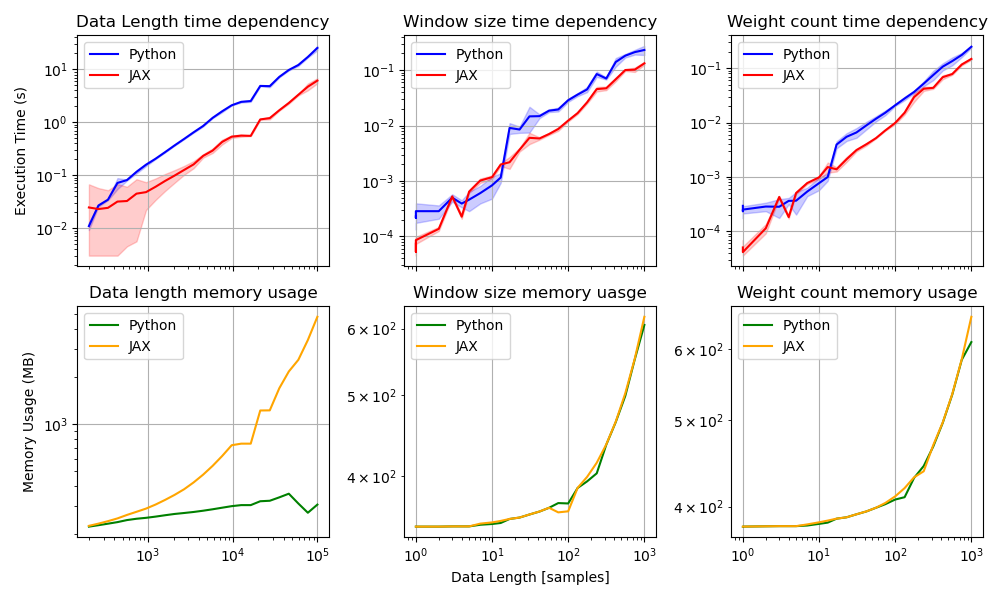

In [20]:
# Load benchmark results for each category
window_keys = ["python_window_times", "python_window_memory", "jax_window_times", "jax_window_memory"]
weight_keys = ["python_weight_times", "python_weight_memory", "jax_weight_times", "jax_weight_memory"]
length_keys = ["python_length_times", "python_length_memory", "jax_length_times", "jax_length_memory"]
# Overview specifier
keys = ["length", "window", "weight"]

window_results = load_benchmark_results(window_keys)
weight_results = load_benchmark_results(weight_keys)
length_results = load_benchmark_results(length_keys)
benchmarks = [length_results, window_results, weight_results]

# Assuming data_lengths, weight_counts, and window_counts are defined as in your setup
data_lengths = np.logspace(
    np.log10(setup["data_length_min"]),
    np.log10(setup["data_length_max"]),
    num=setup["data_length_test_logSamples"],
)

weight_counts = np.logspace(
    np.log10(setup["weight_test_min_weight_count"]),
    np.log10(setup["weight_test_max_weight_count"]),
    num=setup["weight_test_logSamples"],
    dtype=np.int32,
)

window_counts = np.logspace(
    np.log10(setup["weight_test_min_weight_count"]),
    np.log10(setup["weight_test_max_weight_count"]),
    num=setup["weight_test_logSamples"],
    dtype=np.int32,
)

data_x_lengths = [data_lengths, weight_counts, window_counts]
titles_0 = [
    "Data Length time dependency",
    "Window size time dependency",
    "Weight count time dependency",
]
titles_1 = [
    "Data length memory usage",
    "Window size memory uasge",
    "Weight count memory usage",
]

# Create a 2x3 subplot layout
fig, axs = plt.subplots(2, 3, figsize=(10, 6))


for i, benchmark in enumerate(benchmarks):
    # Load times and memory usage for Python and JAX
    python_times = benchmark[f"python_{keys[i]}_times"]
    jax_times = benchmark[f"jax_{keys[i]}_times"]
    python_memory = benchmark[f"python_{keys[i]}_memory"]
    jax_memory = benchmark[f"jax_{keys[i]}_memory"]

    # Extract statistics for times
    python_means = np.array([d["mean"] for d in python_times])
    python_std = np.array([np.std(d["raw_times"], ddof=1) for d in python_times])
    jax_means = np.array([d["mean"] for d in jax_times])
    jax_std = np.array([np.std(d["raw_times"], ddof=1) for d in jax_times])

    # Determine the minimum execution time across both implementations for a proper lower bound in plots
    absolute_min_time = min(*(d["min"] for d in python_times), *(d["min"] for d in jax_times))
    python_lower_bound = np.maximum(python_means - python_std, absolute_min_time)
    jax_lower_bound = np.maximum(jax_means - jax_std, absolute_min_time)

    # Plot execution times
    axs[0, i].plot(data_x_lengths[i], python_means, label="Python", color="blue")
    axs[0, i].fill_between(
        data_x_lengths[i], python_lower_bound, python_means + python_std, color="blue", alpha=0.2
    )
    axs[0, i].plot(data_x_lengths[i], jax_means, label="JAX", color="red")
    axs[0, i].fill_between(data_x_lengths[i], jax_lower_bound, jax_means + jax_std, color="red", alpha=0.2)
    axs[0, i].set_title(titles_0[i])
    axs[0, i].set_xscale("log")
    axs[0, i].set_yscale("log")
    # axs[0, i].set_xlabel("Data Length")
    # axs[0, i].set_ylabel("Execution Time (s)")
    axs[0, i].legend()
    axs[0, i].grid()

    # Plot memory usages
    axs[1, i].plot(data_x_lengths[i], python_memory, label="Python", color="green")
    axs[1, i].plot(data_x_lengths[i], jax_memory, label="JAX", color="orange")
    axs[1, i].sharex(axs[0, i])
    axs[1, i].set_title(titles_1[i])
    axs[1, i].set_xscale("log")
    axs[1, i].set_yscale("log")
    # axs[1, i].set_xlabel("Data Length [samples]")
    # axs[1, i].set_ylabel("Memory Usage (MB)")
    axs[1, i].legend()
    axs[1, i].grid()

    axs[0, i].tick_params(labelbottom=False)

axs[0, 0].set_ylabel("Execution Time (s)")
axs[1, 0].set_ylabel("Memory Usage (MB)")
axs[1, 1].set_xlabel("Data Length [samples]")

plt.tight_layout()
plt.show()


In [21]:
plt.savefig("../test_local/images/3_overview.svg")

## Quantification of Memory Usage Growth in JAX
Due to the rapid increase in memory usage observed in the JAX implementation, we have quantified this growth by fitting linear, quadratic, and cubic functions to the measured memory consumption data.

Based on the R² values, we observe that the growth is predominantly linear, with R² values close to 0.98 for the linear fits. The quadratic and cubic fits achieve slightly higher R² values around 0.99, indicating only a marginal difference.

Specifically, we can quantify the linear memory growth for each test as follows
* **Data Length**: Linear memory growth rate is approximately **0.0423 MB** per data point.
* **Window Size**: Linear memory growth rate is approximately **0.1857 MB** per data point.
* **Weight Count**: Linear memory growth rate is approximately **0.2398 MB** per data point.

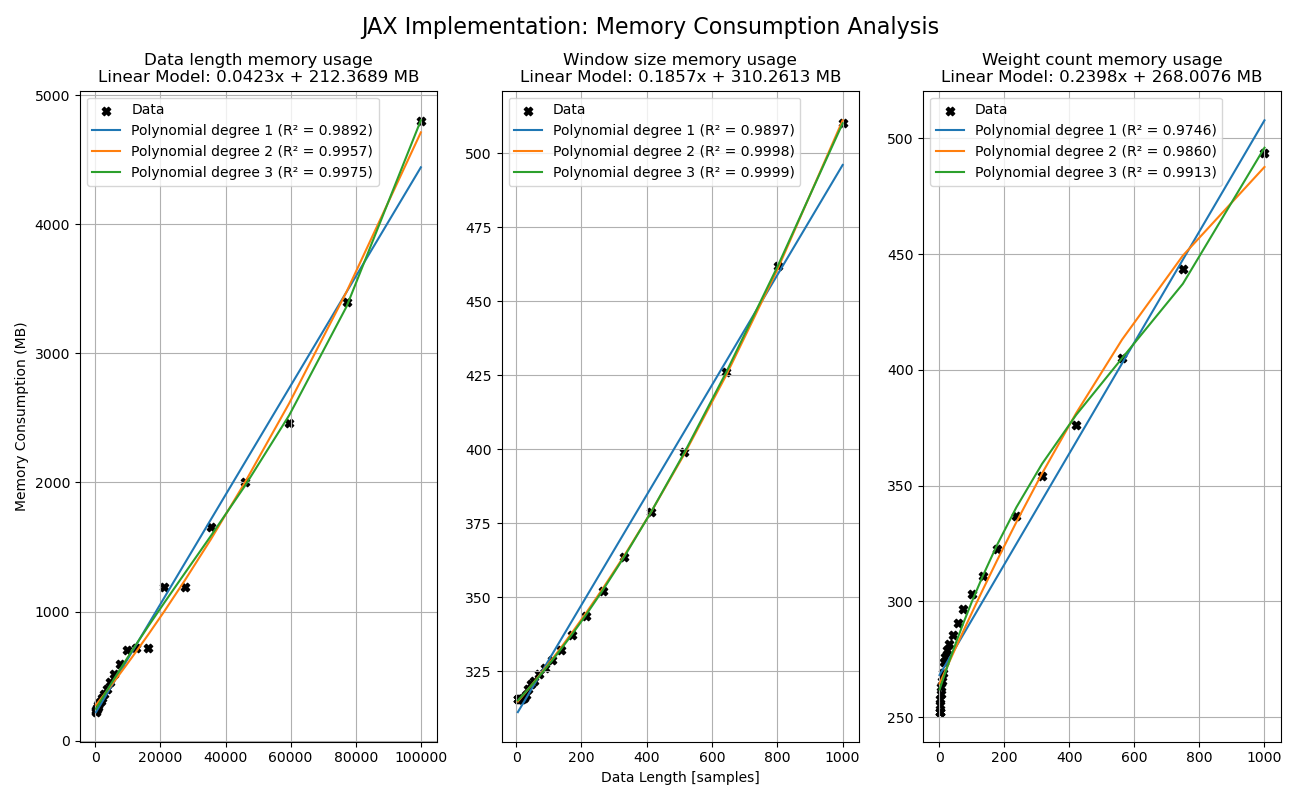

In [22]:
# Function to fit polynomial models, calculate R-squared, and plot them with growth rate in the title
def plot_with_polynomials_and_growth(ax, x, y, color, x_label):
    ax.scatter(x, y, color=color, marker='X', label='Data')
    ax.grid()

    # Fit linear model to get the growth rate
    linear_model = LinearRegression().fit(x.reshape(-1, 1), y)
    linear_growth_rate = linear_model.coef_[0]
    intercept = linear_model.intercept_
    ax.set_title(f'{x_label} memory usage\nLinear Model: {linear_growth_rate:.4f}x + {intercept:.4f} MB')

    # Fit linear, quadratic, and cubic models
    for degree in [1, 2, 3]:
        poly = PolynomialFeatures(degree)
        x_poly = poly.fit_transform(x.reshape(-1, 1))
        model = LinearRegression().fit(x_poly, y)
        y_poly_pred = model.predict(x_poly)
        r2 = r2_score(y, y_poly_pred)
        ax.plot(x, y_poly_pred, label=f'Polynomial degree {degree} (R² = {r2:.4f})')

    ax.legend()


combined_df = pd.read_csv("./example_3_memory_data.csv")

# Create horizontal subplots for each test with polynomial fits and growth rate in the title
fig, axs = plt.subplots(1, 3, figsize=(13, 8))

# Plot Data Length vs Memory Consumption
plot_with_polynomials_and_growth(axs[0], combined_df['Data Length'].values, combined_df['Memory Consumption (Length)'].values, 'black', 'Data length')
axs[0].set_ylabel('Memory Consumption (MB)')

# Plot Window Size vs Memory Consumption
plot_with_polynomials_and_growth(axs[1], combined_df['Window Size'].values, combined_df['Memory Consumption (Window)'].values, 'black', 'Window size')
axs[1].set_xlabel('Data Length [samples]')

# Plot Weight Count vs Memory Consumption
plot_with_polynomials_and_growth(axs[2], combined_df['Weight Count'].values, combined_df['Memory Consumption (Weight)'].values, 'black', 'Weight count')

# Remove redundant labels
for ax in axs[1:]:
    ax.set_ylabel('')

# Add a figure title
fig.suptitle('JAX Implementation: Memory Consumption Analysis', fontsize=16)


plt.tight_layout()
plt.show()